# Setup (same everywhere)

## Mount Drive


In [4]:
from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
%cd drive/'My Drive'/repositories/moleculenet/notebooks

/content/drive/My Drive/repositories/moleculenet/notebooks


In [59]:
%ls

all_plots.ipynb
colab_extended_ci_rf_and_gp_saving_results.ipynb
colab_extended_GPflow_pipeline.ipynb
colab_extended_grid_search_pipeline.ipynb
colab_reproducing_ci_gp.ipynb
colab_reproducing_ci_rf.ipynb
colab_reproducing_grid_search_pipeline.ipynb
eda.ipynb
prepare_extended_grid_search_results.ipynb
prepare_reproducing_grid_search_results.ipynb


In [60]:
%ls ../data/

esol_original_1024ecfp4_features.csv
esol_original_1024ecfp6_features.csv
esol_original_2048ecfp4_features.csv
esol_original_2048ecfp6_features.csv
esol_original.csv
esol_original_extra_features.csv
esol_original_IdSmilesLabels.csv
esol_original_rdkit_features.csv
ESOL_README
freesolv_original_1024ecfp4_features.csv
freesolv_original_1024ecfp6_features.csv
freesolv_original_2048ecfp4_features.csv
freesolv_original_2048ecfp6_features.csv
freesolv_original.csv
freesolv_original_IdSmilesLabels.csv
freesolv_original_rdkit_features.csv
FreeSolv_README
lipophilicity_original_1024ecfp4_features.csv
lipophilicity_original_1024ecfp6_features.csv
lipophilicity_original_2048ecfp4_features.csv
lipophilicity_original_2048ecfp6_features.csv
lipophilicity_original.csv
lipophilicity_original_IdSmilesLabels.csv
lipophilicity_original_rdkit_features.csv
Lipo_README


## Import modules

### Standard imports

In [61]:
import warnings
warnings.filterwarnings('ignore')

# custom imports
import os
import sys

# saving models
import json
import pickle

# standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# metrics
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import jaccard_score # Tanimoto

# making custom metrics
from sklearn.metrics import make_scorer

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict

# preprocessing
from sklearn.feature_selection import VarianceThreshold # to remove zero-var features
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

# models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.kernel_ridge import KernelRidge

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct

# pipelines
# https://scikit-learn.org/stable/modules/compose.html#combining-estimators
from sklearn.pipeline import make_pipeline, Pipeline

In [62]:
try:
    import forestci as fci
    print("Successful import")
except ImportError as e:
    ! pip install forestci
    import forestci as fci

Successful import


In [63]:
import sklearn
print(sklearn.__version__)
print(fci.__version__)

0.22.2.post1
0.4.1


### Custom imports

In [64]:
sys.path.insert(0, '..')

# preprocessing
from util_scripts.preprocessing_functions import list_highly_correlated

# plotting
from util_scripts.plotting_functions_and_vars import FIGSIZE_CI, FIGSIZE_HEATMAP, PLOTS_DIR
from util_scripts.plotting_functions_and_vars import datasets_to_titles, datasets_to_units, metrics_to_labels

sys.path.insert(0, './notebooks')

In [65]:
help(list_highly_correlated)

Help on function list_highly_correlated in module util_scripts.preprocessing_functions:

list_highly_correlated(df_features, targets, threshold=0.8)
    List column names of the dataframe of features which are highly correlated
    to the target (absolute value of the correlation is greater than the threshold).
    
    Parameters
    ----------
    df_features : (n, p) pandas.core.frame.DataFrame of p features
                  Input array.
    targets     : (n,) pandas.core.series.Series of targets
                  Input array.
    threshold   : float in [0, 1] above which we consider a feature highly correlated
    
    Returns
    -------
    cols_to_remove : list of column names from df_features, which are highly correlated
                     to the target



In [66]:
def make_split_generator(X, y, split_type='random', random_state=42, n_splits=1, test_size=0.1):
    assert split_type in ['random', 'stratified']

    if split_type == 'random':
        gen = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state).split(X)
    elif split_type == 'stratified':
        binned = y.apply(lambda x: int(x)) # creating stratified indices
        gen = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state).split(X, binned)
    
    # gen for generator
    return gen

## Set plotting style

In [67]:
%matplotlib inline
plt.style.use('fivethirtyeight')

plt.rcParams['axes.facecolor']='w'
#plt.rcParams['axes.linewidth']=1
plt.rcParams['axes.edgecolor']='w'
plt.rcParams['figure.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
#plt.rcParams['grid.color']='white'

# Load Data (same everywhere)

## CHOOSE: dataset, smile_type, grid_search_type

In [241]:
dataset = 'esol'
assert dataset in ['freesolv', 'esol', 'lipophilicity']

smile_type = 'original'
assert smile_type in ['original', 'protonated']

grid_search_type = 'extended'
assert grid_search_type in ['reproducing', 'extended']

remove_highly_correlated = True
assert isinstance(remove_highly_correlated, bool)

# for saving files depending on highly-correlated feature treatment
# cf stands for correlated features
if remove_highly_correlated:
    cf = 'reduced'
else:
    cf = 'full'

In [242]:
print(dataset, smile_type, grid_search_type, cf)

esol original extended reduced


## Titles, Units and Labels for datasets

In [243]:
for key, value in datasets_to_titles.items():
    print(key, (13 - len(key))*' ' + ': ',  value)

freesolv      :  Solvation Energy
esol          :  Log Solubility
lipophilicity :  Octanol/Water Distribution Coefficient


In [244]:
for key, value in datasets_to_units.items():
    print(key, (13 - len(key))*' ' + ': ',  value)

freesolv      :  (kcal/mol)
esol          :  (mol/litre)
lipophilicity :  (logD)


## Load Features and Targets

Leave all features here so setup and Load and prepare data are the same everywhere.

In [245]:
# original data
id_smile_target = pd.read_csv(f'../data/{dataset}_{smile_type}_IdSmilesLabels.csv', index_col=0)
# labels
labels = id_smile_target['labels']

In [246]:
# fingerprints
ecfp4_1024_features = pd.read_csv(f'../data/{dataset}_{smile_type}_1024ecfp4_features.csv', index_col=0)
ecfp6_1024_features = pd.read_csv(f'../data/{dataset}_{smile_type}_1024ecfp6_features.csv', index_col=0)

ecfp4_2048_features = pd.read_csv(f'../data/{dataset}_{smile_type}_2048ecfp4_features.csv', index_col=0)
ecfp6_2048_features = pd.read_csv(f'../data/{dataset}_{smile_type}_2048ecfp6_features.csv', index_col=0)

In [247]:
# RDKit descriptors
rdkit_features = pd.read_csv(f'../data/{dataset}_{smile_type}_rdkit_features.csv', index_col=0)

if remove_highly_correlated:
    highly_correlated_features = list_highly_correlated(rdkit_features, labels, threshold=0.75)
    print(f'\nRemoving {len(highly_correlated_features)} highly correlated feature(s).')
    rdkit_features = rdkit_features.drop(highly_correlated_features, axis=1)


Found 1 highly-correlated feature(s):
['MolLogP']

Removing 1 highly correlated feature(s).


In [248]:
print('rdkit_features.shape:      ', rdkit_features.shape)
print('ecfp4_1024_features.shape: ', ecfp4_1024_features.shape)
print('ecfp6_1024_features.shape: ', ecfp6_1024_features.shape)
print('ecfp4_2048_features.shape: ', ecfp4_2048_features.shape)
print('ecfp6_2048_features.shape: ', ecfp6_2048_features.shape)
print('labels.shape:              ', labels.shape)

rdkit_features.shape:       (1128, 199)
ecfp4_1024_features.shape:  (1128, 1024)
ecfp6_1024_features.shape:  (1128, 1024)
ecfp4_2048_features.shape:  (1128, 2048)
ecfp6_2048_features.shape:  (1128, 2048)
labels.shape:               (1128,)


In [249]:
labels.head()

id
Amigdalin   -0.77
Fenfuram    -3.30
citral      -2.06
Picene      -7.87
Thiophene   -1.33
Name: labels, dtype: float64

## Create one DataFrame with all features

In [250]:
all_features = pd.concat([rdkit_features,
                          ecfp4_1024_features, ecfp6_1024_features,
                          ecfp4_2048_features, ecfp6_2048_features],
                         axis='columns')

In [251]:
all_features.shape

(1128, 6343)

In [252]:
all_features.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,...,2048ecfp6-2008,2048ecfp6-2009,2048ecfp6-2010,2048ecfp6-2011,2048ecfp6-2012,2048ecfp6-2013,2048ecfp6-2014,2048ecfp6-2015,2048ecfp6-2016,2048ecfp6-2017,2048ecfp6-2018,2048ecfp6-2019,2048ecfp6-2020,2048ecfp6-2021,2048ecfp6-2022,2048ecfp6-2023,2048ecfp6-2024,2048ecfp6-2025,2048ecfp6-2026,2048ecfp6-2027,2048ecfp6-2028,2048ecfp6-2029,2048ecfp6-2030,2048ecfp6-2031,2048ecfp6-2032,2048ecfp6-2033,2048ecfp6-2034,2048ecfp6-2035,2048ecfp6-2036,2048ecfp6-2037,2048ecfp6-2038,2048ecfp6-2039,2048ecfp6-2040,2048ecfp6-2041,2048ecfp6-2042,2048ecfp6-2043,2048ecfp6-2044,2048ecfp6-2045,2048ecfp6-2046,2048ecfp6-2047
Amigdalin,10.069684,-5.122500,10.069684,0.911295,0.217518,457.432,430.216,457.158411,178.0,0.0,0.210849,-0.393567,0.393567,0.210849,0.781250,1.312500,1.843750,2.512447,1822.972785,46.449383,41.937945,14.937945,26.489135,20.643207,7.785469,5.261208,5.261208,3.350174,3.350174,1.916053,1.916053,-1.73,4.967252e+11,7.382237,10.926356,5.251706,221.476223,54.709109,48.640144,18.612175,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Fenfuram,12.547837,-2.999280,12.547837,0.099444,0.811283,201.225,190.137,201.078979,76.0,0.0,0.258698,-0.468799,0.468799,0.258698,1.333333,2.066667,2.800000,2.680215,872.797237,20.135310,18.263710,7.263710,11.801324,9.256800,3.809586,2.423811,2.423811,1.470204,1.470204,0.842712,0.842712,-2.03,3.091769e+05,2.980514,4.002882,2.070849,103.236827,9.726964,7.131006,1.411842,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
citral,11.071016,-3.884051,11.071016,1.707414,0.343706,152.237,136.109,152.120115,62.0,0.0,0.142281,-0.298566,0.298566,0.142281,1.181818,1.909091,2.454545,7.099519,638.159152,22.386751,21.408248,5.408248,11.502777,10.454124,2.454124,1.352062,1.352062,0.551031,0.551031,0.238531,0.238531,-0.85,9.152531e+04,1.343483,5.899351,7.042356,91.285574,0.000000,7.632971,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Picene,8.745488,-0.641794,8.745488,0.260568,0.291526,278.354,264.242,278.109550,102.0,0.0,0.062969,-0.061629,0.062969,0.061629,0.227273,0.409091,0.772727,2.297464,1736.538251,26.701706,25.000000,11.000000,16.749570,13.500000,6.500000,4.750000,4.750000,3.562500,3.562500,2.562500,2.562500,-2.86,7.369089e+07,4.565966,4.315741,1.523286,147.827648,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Thiophene,6.980324,-0.134259,6.980324,0.004630,0.448927,84.143,80.111,84.003371,26.0,0.0,0.073940,-0.152454,0.152454,0.073940,1.400000,2.000000,2.200000,3.292166,206.216662,7.016508,6.408248,3.224745,4.125898,3.158248,1.974745,0.556186,1.168559,0.266624,0.674872,0.127578,0.382733,-0.30,1.091618e+02,0.850086,1.221050,0.484065,40.691648,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# CHOOSE: what feature_sets we will iterate over

## Put original features into feature_sets
Create a dictionary containing feature names (index objects) as its elements

In [253]:
feature_sets = {
    'RDKit': rdkit_features.columns,
    '1024ecfp-4': ecfp4_1024_features.columns,
    '1024ecfp-6': ecfp6_1024_features.columns,
    '2048ecfp-4': ecfp4_2048_features.columns,
    '2048ecfp-6': ecfp6_2048_features.columns,
}

## Adding a combination of RDKit features with every feature set in the feature_sets dictionary


In [254]:
for f in ['1024ecfp-4', '1024ecfp-6', '2048ecfp-4', '2048ecfp-6']:
    feature_sets[f'{f} + RDKit'] = feature_sets[f].union(feature_sets['RDKit'])

In [255]:
list(feature_sets.keys())

['RDKit',
 '1024ecfp-4',
 '1024ecfp-6',
 '2048ecfp-4',
 '2048ecfp-6',
 '1024ecfp-4 + RDKit',
 '1024ecfp-6 + RDKit',
 '2048ecfp-4 + RDKit',
 '2048ecfp-6 + RDKit']

# List of estimators

In [256]:
estimators = {
    'rf':  RandomForestRegressor(),
    'xgb': XGBRegressor(),
    'krr': KernelRidge(kernel='rbf'), # 'rbf' used in the paper (defaults to 'linear')
    'gp': GaussianProcessRegressor(normalize_y=True), # normilize since we have not normalized here
}

## Load best parameters

In [257]:
with open(f'../results/{dataset}_{smile_type}_{grid_search_type}_random_search_best_params_{cf}.pickle', 'rb') as fp:
    best_params = pickle.load(fp)

In [258]:
best_params

{'1024ecfp-4': {'gp': {'gp__kernel': Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)},
  'krr': {'krr__alpha': 0.01},
  'rf': {'rf__max_features': 0.1, 'rf__n_estimators': 800},
  'xgb': {'xgb__learning_rate': 0.2,
   'xgb__max_depth': 9,
   'xgb__n_estimators': 300,
   'xgb__subsample': 0.5}},
 '1024ecfp-4 + RDKit': {'gp': {'gp__kernel': RBF(length_scale=1) + WhiteKernel(noise_level=1)},
  'krr': {'krr__alpha': 0.01},
  'rf': {'rf__max_features': 0.4, 'rf__n_estimators': 950},
  'xgb': {'xgb__learning_rate': 0.1,
   'xgb__max_depth': 5,
   'xgb__n_estimators': 200,
   'xgb__subsample': 0.5}},
 '1024ecfp-6': {'gp': {'gp__kernel': Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)},
  'krr': {'krr__alpha': 0.0001},
  'rf': {'rf__max_features': 0.1, 'rf__n_estimators': 800},
  'xgb': {'xgb__learning_rate': 0.1,
   'xgb__max_depth': 5,
   'xgb__n_estimators': 200,
   'xgb__subsample': 0.5}},
 '1024ecfp-6 + RDKit': {'gp': {'gp__kernel': RBF(length_scale=1) + WhiteKerne

# Best combination feature-set * estimator for RFs and GPs

In [259]:
#%ls ../tables/

In [260]:
df_best_model_featureset = pd.read_csv(f'../tables/{dataset}_{smile_type}_{grid_search_type}_{cf}_best_test_RMSE_model_x_featureset_mean_std.csv')

print('dataset', 'smile_type', 'grid_search_type', 'cf')
print(dataset, smile_type, grid_search_type, cf)
df_best_model_featureset

dataset smile_type grid_search_type cf
esol original extended reduced


,Model,Feature set,mean,std
0,xgb,RDKit,0.601883,0.078263
1,gp,RDKit,0.664609,0.033078
2,rf,RDKit,0.730515,0.087297
3,krr,RDKit,0.877072,0.011973
4,gpflow,2048ecfp-6,1.029373,0.009862


# Getting best featureset for a model of choice

## Choose model

In [261]:
f_gp = df_best_model_featureset[df_best_model_featureset['Model'] == 'gp']['Feature set'].values[0]
f_gp

'RDKit'

In [262]:
f_rf = df_best_model_featureset[df_best_model_featureset['Model'] == 'rf']['Feature set'].values[0]
f_rf

'RDKit'

# Get best parameters for rf and gp for these featuresets

In [263]:
params_gp = best_params[f_gp]['gp']
params_gp

{'gp__kernel': Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)}

In [264]:
params_rf = best_params[f_rf]['rf']
params_rf

{'rf__max_features': 0.4, 'rf__n_estimators': 950}

## Create models and check we can feed them parameters

In [265]:
rf = RandomForestRegressor(
        n_estimators = params_rf['rf__n_estimators'],
        max_features = params_rf['rf__max_features'],
        random_state=42)
rf

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=950, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [266]:
gpr = GaussianProcessRegressor(
        kernel = params_gp['gp__kernel'],
        random_state=42,
        n_restarts_optimizer=3)
gpr

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=3, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=42)

## Functions to get predictions and standard errors

In [267]:
def fit_rf_ci(X_train_prepared, X_test_prepared, y_train, params_rf):
    # initiaalise
    rf = RandomForestRegressor(
        n_estimators = params_rf['rf__n_estimators'],
        max_features = params_rf['rf__max_features'],
        random_state=42)
    
    # fit
    rf.fit(X_train_prepared, y_train)
    
    # predict
    y_test_pred = rf.predict(X_test_prepared)
    
    # get CIs
    # Calculate the variance
    V_IJ_unbiased = fci.random_forest_error(rf, X_train_prepared, X_test_prepared)
    y_test_std = np.sqrt(V_IJ_unbiased)
    
    return y_test_pred, y_test_std

In [268]:
def fit_gp_ci(X_train_prepared, X_test_prepared, y_train, params_gp):
    # initiaalise
    gpr = GaussianProcessRegressor(
        kernel = params_gp['gp__kernel'],
        random_state=42,
        n_restarts_optimizer=3)
    
    # fit
    gpr.fit(X_train_prepared, y_train)
    
    # predict and get stds
    y_test_pred, y_test_std = gpr.predict(X_test_prepared, return_std=True)
    
    return y_test_pred, y_test_std

# Try one run and record times

In [269]:
pipe = Pipeline([('zero-var-feature-remover', VarianceThreshold()),
                 ('scaler', StandardScaler())
                ])

## One run RF

### Data

In [270]:
X = all_features[feature_sets[f_rf]].dropna(axis=0)
y = labels[X.index]
X.shape, y.shape
# X.isna().sum().sum(), y.isna().sum()

((1128, 199), (1128,))

In [271]:
split_gen = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42).split(X)

In [272]:
for train, test in split_gen:
    # train-test split
    X_train = X.iloc[train]
    y_train = y.iloc[train].values
    X_test = X.iloc[test]
    y_test = y.iloc[test].values
    
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((902, 199), (226, 199), (902,), (226,))

In [273]:
X_train_prepared = pipe.fit_transform(X_train)
X_test_prepared = pipe.transform(X_test)

In [274]:
%%time
y_test_pred, y_test_std = fit_rf_ci(X_train_prepared, X_test_prepared, y_train, params_rf)

CPU times: user 17.5 s, sys: 268 ms, total: 17.8 s
Wall time: 17.6 s


## One run GP

### Data

In [275]:
X = all_features[feature_sets[f_gp]].dropna(axis=0)
y = labels[X.index]

In [276]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [277]:
X_train_prepared = pipe.fit_transform(X_train)
X_test_prepared = pipe.transform(X_test)

In [278]:
### Fit

In [279]:
%%time
y_test_pred, y_test_std = fit_gp_ci(X_train_prepared, X_test_prepared, y_train, params_gp)

CPU times: user 52 s, sys: 12.4 s, total: 1min 4s
Wall time: 35.5 s


## Plot the results for test and train observations

# Confidence Intervals

## Calculate confidence bounds using std part of gpr predictions

In [280]:
len(y_test_pred)

226

In [281]:
upper = y_test_pred + 1.96 * y_test_std
lower = y_test_pred - 1.96 * y_test_std

In [282]:
CIs_df = pd.DataFrame(
    {'y_test': y_test,
     'y_test_pred': y_test_pred,
     'y_test_std': y_test_std,
     'lower': lower,
     'upper': upper}
)
CIs_df = CIs_df.sort_values(by='y_test')

In [283]:
CIs_df

,y_test,y_test_pred,y_test_std,lower,upper
Perylene,-8.804,-8.575784,0.398185,-9.356226,-7.795342
"2,2',3,3',5,6-PCB",-8.600,-8.045872,0.369206,-8.769516,-7.322227
Benzo(k)fluoranthene,-8.490,-7.973270,0.427852,-8.811859,-7.134680
hexacosane,-8.334,-6.762930,0.699709,-8.134360,-5.391500
Benzo(b)fluoranthene,-8.230,-7.866560,0.428365,-8.706155,-7.026966
...,...,...,...,...,...
Acephate,0.540,-0.764079,0.502494,-1.748968,0.220809
Erythritol,0.700,1.043898,0.446967,0.167842,1.919953
Pyridine,0.760,0.676190,0.426785,-0.160308,1.512687
2-pyrrolidone,1.070,0.565220,0.464149,-0.344512,1.474952


## Plot test observations with error bars (1 std.)

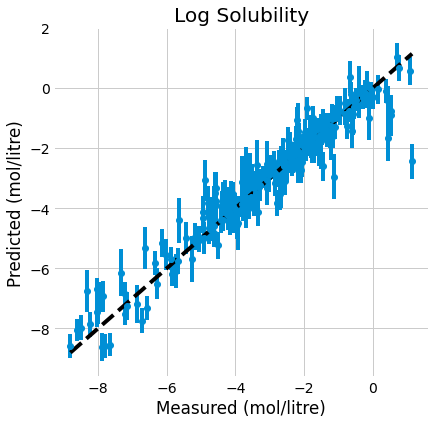

In [284]:
# Plot error bars for predicted quantity using unbiased variance
plt.figure(figsize=FIGSIZE_CI)

plt.errorbar(x=CIs_df.y_test, y=CIs_df.y_test_pred, yerr=CIs_df.y_test_std, fmt='o')
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--')

plt.xlabel(f'Measured {datasets_to_units[dataset]}')
plt.ylabel(f'Predicted {datasets_to_units[dataset]}')
plt.title(f'{datasets_to_titles[dataset]}')

#plt.savefig(f'{PLOTS_DIR}/pubs_units_values.png', bbox_inches='tight')
plt.show()

## Plot 95% confidence intervals

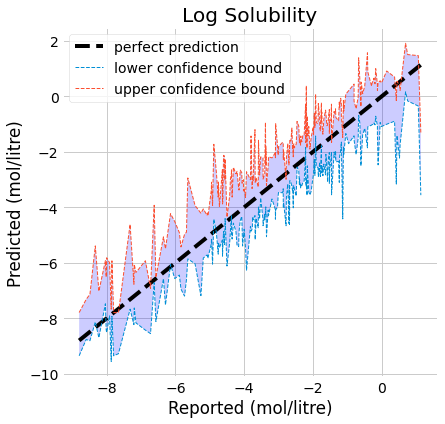

In [285]:
fig, ax = plt.subplots(1, figsize=FIGSIZE_CI)

ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', label='perfect prediction')

ax.plot(CIs_df.y_test, CIs_df.lower, linewidth=1, linestyle='--', label='lower confidence bound')
ax.plot(CIs_df.y_test, CIs_df.upper, linewidth=1, linestyle='--', label='upper confidence bound')
ax.fill_between(CIs_df.y_test, CIs_df.upper, CIs_df.lower, facecolor='blue', alpha=0.2)

ax.set_xlabel(f'Reported {datasets_to_units[dataset]}')
ax.set_ylabel(f'Predicted {datasets_to_units[dataset]}')

ax.set_title(f'{datasets_to_titles[dataset]}')
ax.legend(loc='upper left')

#plt.savefig(f'{PLOTS_DIR}/pubs_units_values.png', bbox_inches='tight')
plt.show()

## Calculate the proportion of measured values in test set within 95% CIs

In [286]:
within_cis = (CIs_df.lower <= CIs_df.y_test) & (CIs_df.y_test <= CIs_df.upper)
within_cis

Perylene                 True
2,2',3,3',5,6-PCB        True
Benzo(k)fluoranthene     True
hexacosane              False
Benzo(b)fluoranthene     True
                        ...  
Acephate                False
Erythritol               True
Pyridine                 True
2-pyrrolidone            True
vamidothion             False
Length: 226, dtype: bool

In [287]:
within_cis.sum() / len(within_cis)

0.9203539823008849

In [288]:
# Multiple runs RF (preprocessing is separate since we have separate features)

In [289]:
X = all_features[feature_sets[f_rf]].dropna(axis=0)
y = labels[X.index]
#X.shape, y.shape
#X.isna().sum().sum(), y.isna().sum()

# change to more afterwarts
split_gen = ShuffleSplit(n_splits=30, test_size=0.2, random_state=42).split(X)

# for records
dict_test_true = {}
dict_test_pred = {}
dict_test_std = {}

count = 0
for train, test in split_gen:
    # train-test split
    X_train = X.iloc[train]
    y_train = y.iloc[train].values
    X_test = X.iloc[test]
    y_test = y.iloc[test].values
        
    # zero-var-reduction and scaling
    X_train_prepared = pipe.fit_transform(X_train)
    X_test_prepared = pipe.transform(X_test)
        
    # getting predictions with uncertainties
    y_test_pred, y_test_std = fit_rf_ci(X_train_prepared, X_test_prepared, y_train, params_rf)
        
    # record results to dictionaries
    dict_test_true[f'test_true_{count}'] = y_test
    dict_test_pred[f'test_pred_{count}'] = y_test_pred
    dict_test_std[f'test_std_{count}'] = y_test_std
    
    # into dataframes
    df_test_true = pd.DataFrame(dict_test_true)
    df_test_pred = pd.DataFrame(dict_test_pred)
    df_test_std = pd.DataFrame(dict_test_std)
    
    # increment for saving results
    count += 1
    
    # save results as csv-s, rewrite each time
    df_test_true.to_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_true_rf.csv', index=False)
    df_test_pred.to_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_pred_rf.csv', index=False)
    df_test_std.to_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_std_rf.csv', index=False)

In [290]:
print('Done with RF')

Done with RF


# Multiple runs GP (preprocessing is separate since we have separate features)

In [291]:
X = all_features[feature_sets[f_gp]].dropna(axis=0)
y = labels[X.index]
#X.shape, y.shape
#X.isna().sum().sum(), y.isna().sum()

# change to more afterwarts
split_gen = ShuffleSplit(n_splits=30, test_size=0.2, random_state=42).split(X)

# for records
dict_test_true = {}
dict_test_pred = {}
dict_test_std = {}

count = 0
for train, test in split_gen:
    # train-test split
    X_train = X.iloc[train]
    y_train = y.iloc[train].values
    X_test = X.iloc[test]
    y_test = y.iloc[test].values
        
    # zero-var-reduction and scaling
    X_train_prepared = pipe.fit_transform(X_train)
    X_test_prepared = pipe.transform(X_test)
        
    # getting predictions with uncertainties
    y_test_pred, y_test_std = fit_gp_ci(X_train_prepared, X_test_prepared, y_train, params_gp)
        
    # record results to dictionaries
    dict_test_true[f'test_true_{count}'] = y_test
    dict_test_pred[f'test_pred_{count}'] = y_test_pred
    dict_test_std[f'test_std_{count}'] = y_test_std
    
    # into dataframes
    df_test_true = pd.DataFrame(dict_test_true)
    df_test_pred = pd.DataFrame(dict_test_pred)
    df_test_std = pd.DataFrame(dict_test_std)
    
    # increment for saving results
    count += 1
    
    # save results as csv-s, rewrite each time
    df_test_true.to_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_true_gp.csv', index=False)
    df_test_pred.to_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_pred_gp.csv', index=False)
    df_test_std.to_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_std_gp.csv', index=False)

In [292]:
print('Done with GP')

Done with GP
